In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from water_pollution.data.preproc import *
from water_pollution.data import stations
from water_pollution.data import stations

from water_pollution.data import visu

In [198]:
# Builds the small training df (from saone data between 2011-2021)
file_path = '../../raw_data/pc_saone_2011_2021/Analyses.CSV'
rawdf = get_rawdf_from_file(file_path)
da_df = build_saone_base_training_data(rawdf)

# # Builds the big training df (from saone data between 1980-2021)
# file_path = '../../raw_data/nitrate_saone_1980_2021/Analyses.CSV'
# rawdf = get_rawdf_from_file(file_path)
# da_df = build_saone_base_training_data(rawdf)

In [199]:
stationsdf = stations.get_saone_stations_df()
# stationsdf.sort_values('alt')

In [200]:
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [201]:
df = da_df.copy()

In [202]:
mean_nitrate = df.groupby('station_id',as_index=False).mean()[['station_id','nitrate']]
mean_nitrate.columns = ['station_id','mean_station']

In [203]:
df_with_mean = pd.merge(df,mean_nitrate,on='station_id',how='left')
df = df_with_mean

In [204]:
# TRAIN / TEST SPLIT

feature_cols = [
    'sin_doy',
    'cos_doy',
    'mean_station',
    # 'source_dist',
    # 'year'
]

X = df[feature_cols]
y = df['nitrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# PREPROCESSING

# Fit on X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all the X
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [205]:
assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [206]:
def init_model(X):
    
    model = models.Sequential()
    
    model.add(layers.Dense(20,activation='relu',input_dim=X.shape[1]))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(20,activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(10,activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=50,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=32, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

In [207]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,100))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

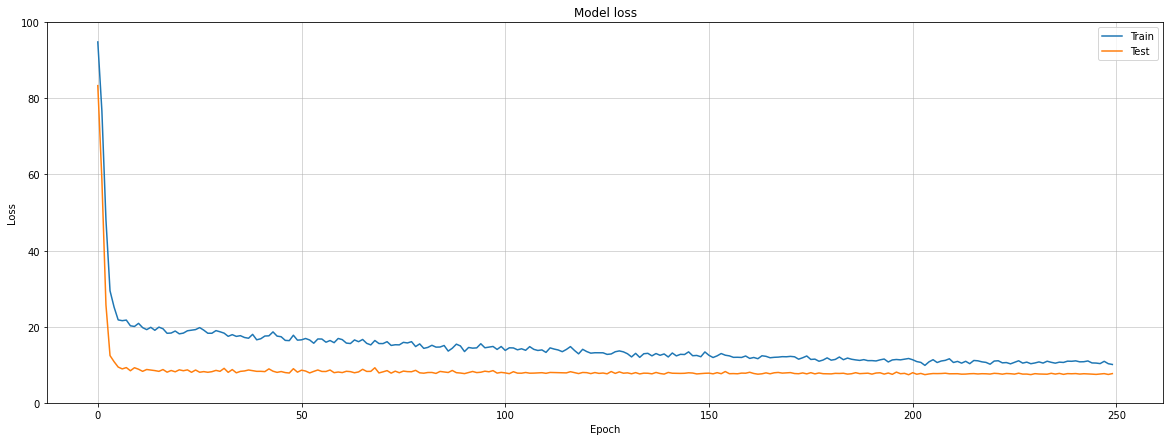

In [208]:
plot_loss(history)

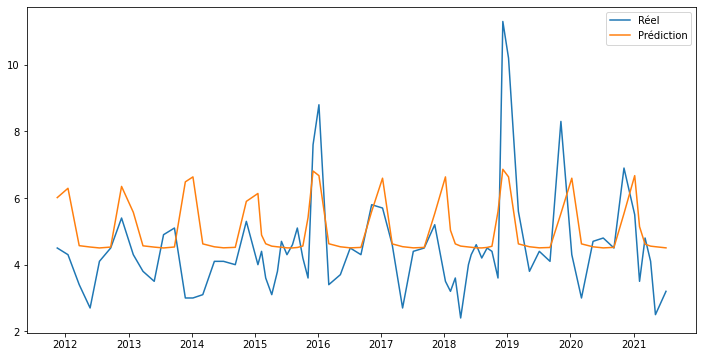

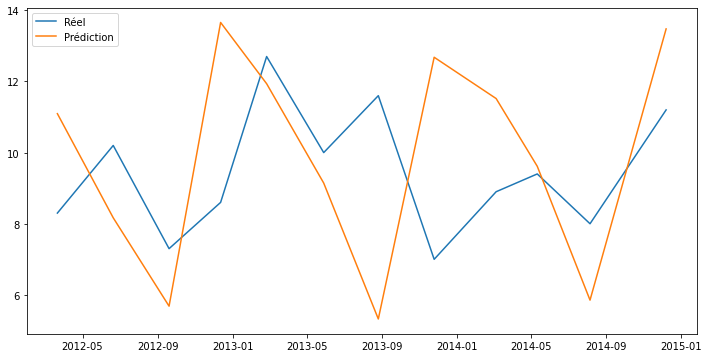

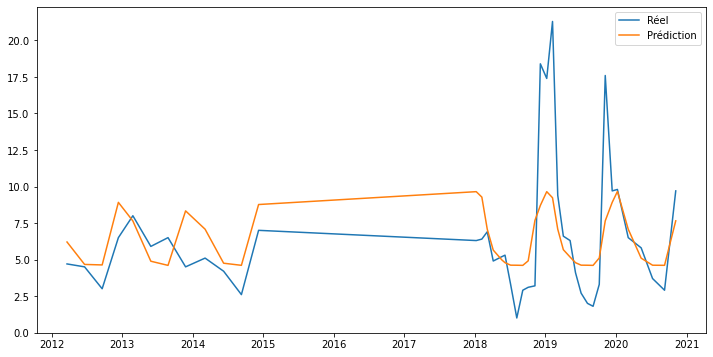

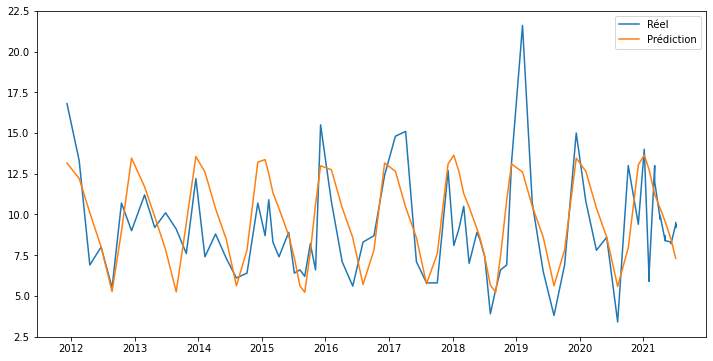

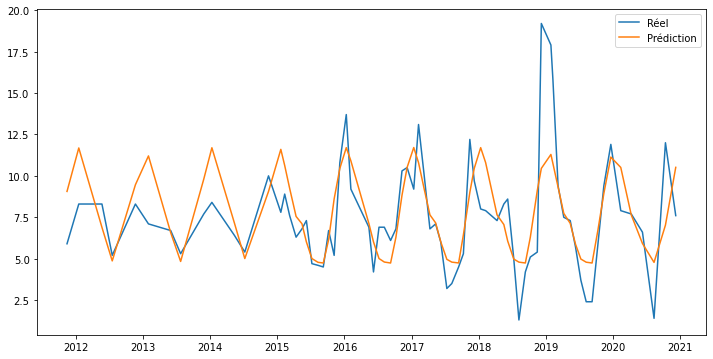

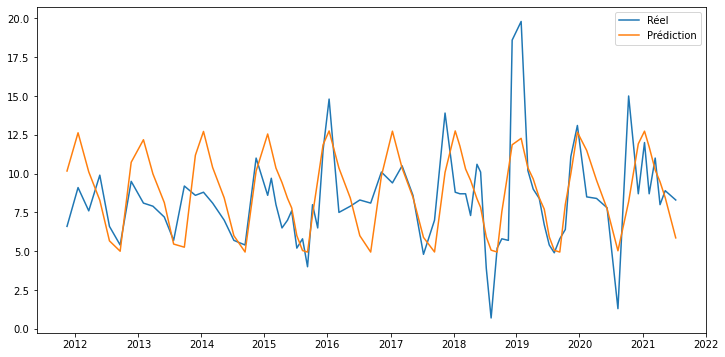

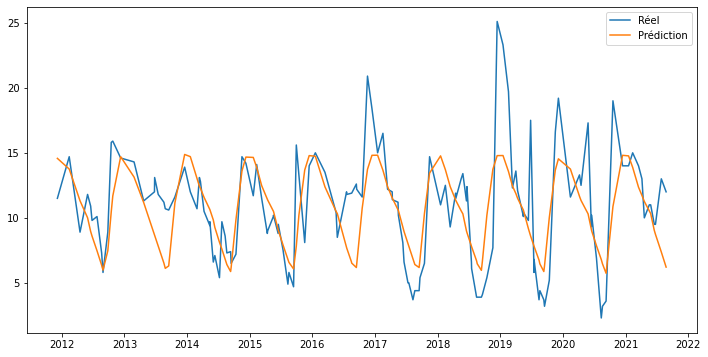

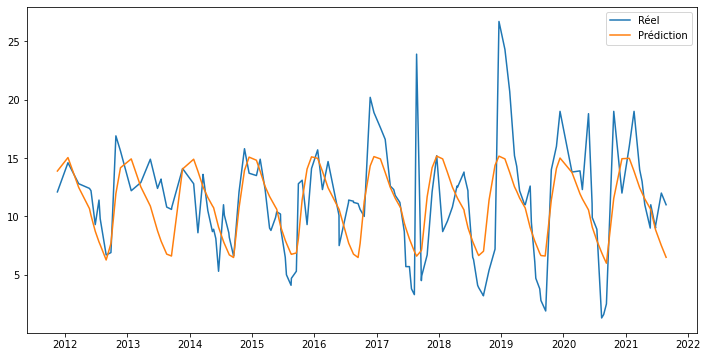

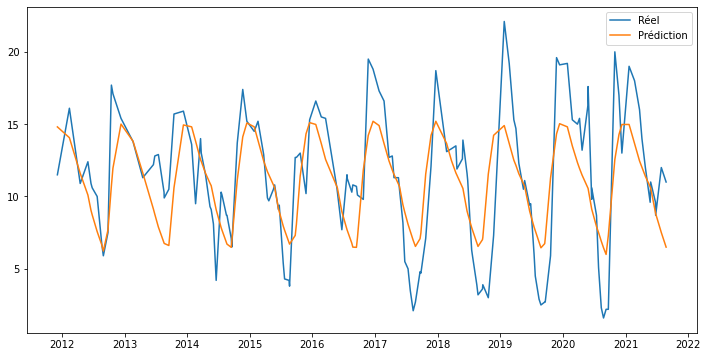

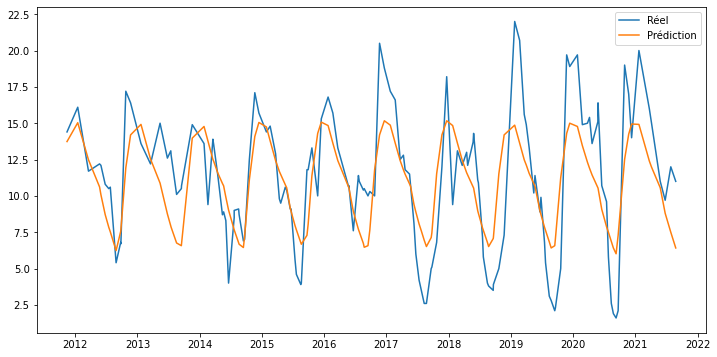

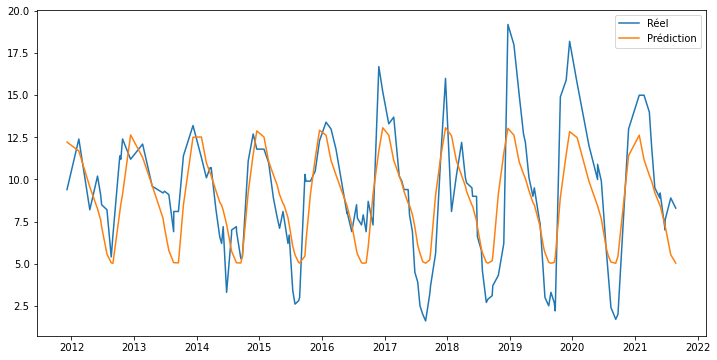

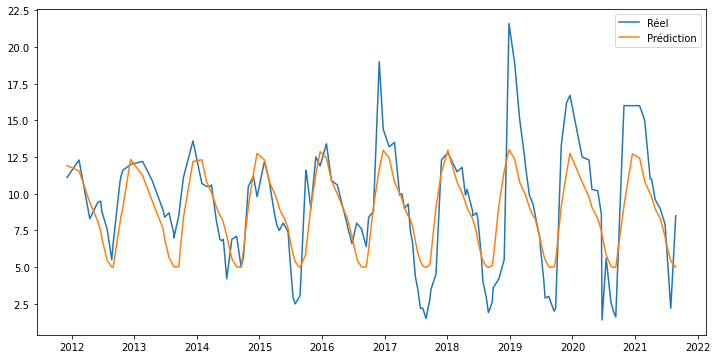

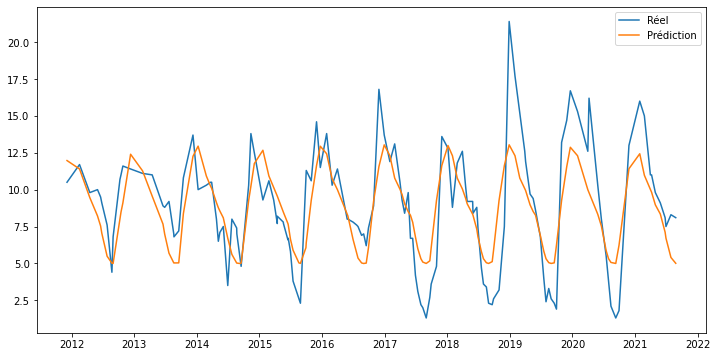

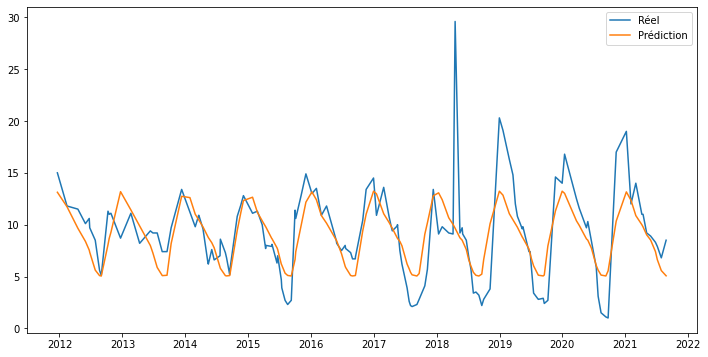

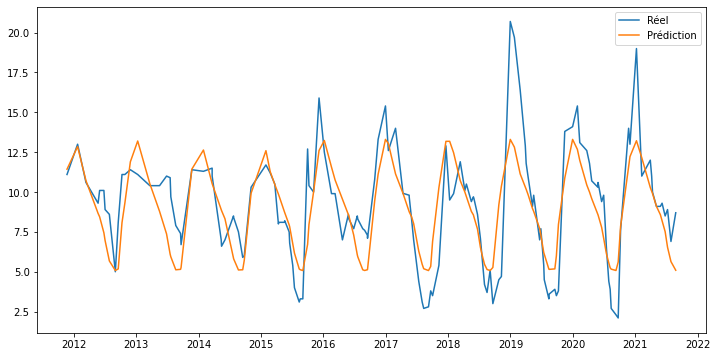

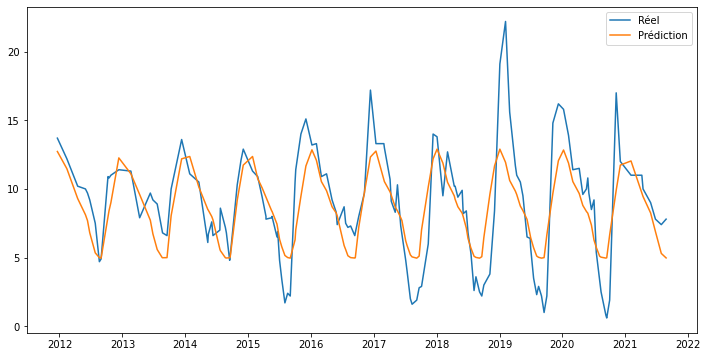

In [209]:
## PLOT STATI0NS PREDICTIONS

station_ids = list(df.station_id.unique())

for st_id in station_ids:

    # df of the station
    st_bool = df['station_id'] == st_id
    st_df = df[st_bool].sort_values('date') # copy sorted

    # X_station
    X_st = st_df[feature_cols]
    X_st = scaler.transform(X_st) # Scaling

    # y prediction
    y_st_pred = model.predict(X_st)
    st_df['nitrate_pred'] = y_st_pred

    plt.figure(figsize=(12,6))
    plt.plot(st_df['date'],st_df['nitrate'],label='Réel')
    plt.plot(st_df['date'],st_df['nitrate_pred'],label='Prédiction')
    plt.legend()
    plt.show()